In [ ]:
accelerate launch train_dreambooth_inpaint.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-inpainting" \
    --instance_data_dir="dataset_finetuning/trash_plastic/" \
    --output_dir="stable-diffusion-inpainting-metal-plastic-500" \
    --instance_prompt="a plastic trash in the sea" \
    --resolution=512 \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=400 \
    --gradient_accumulation_steps=2 \
    --gradient_checkpointing \
    --train_text_encoder


SyntaxError: invalid syntax (3658634487.py, line 1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 28.89it/s]


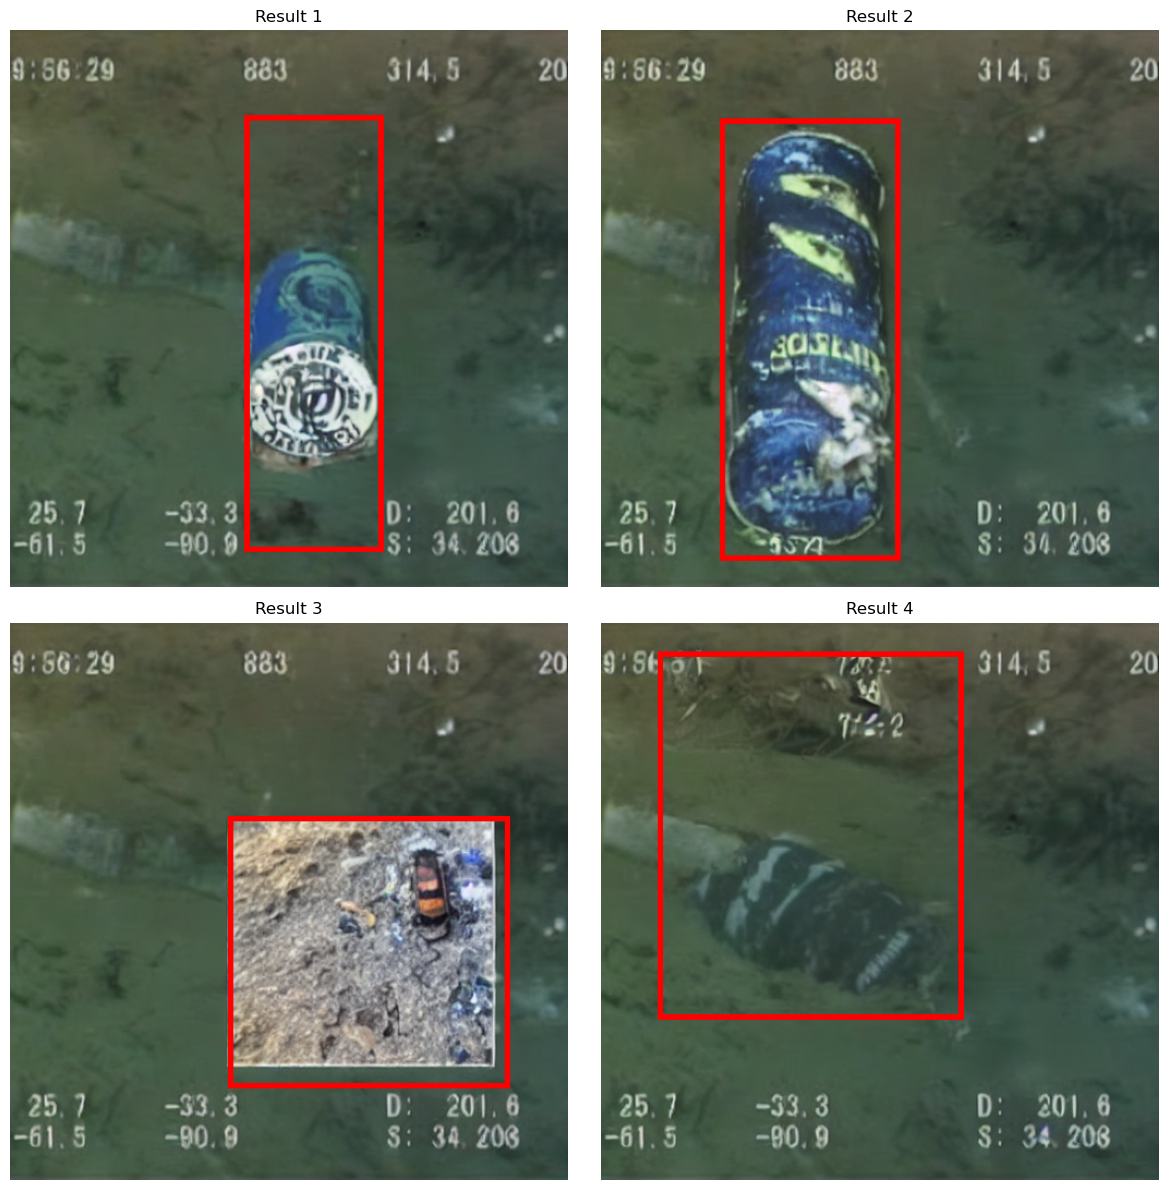

In [8]:
from PIL import Image, ImageDraw
from diffusers import StableDiffusionInpaintPipeline
import torch
import matplotlib.pyplot as plt
import math
import random

# Function to generate a random mask with a rectangular fill
def generate_random_mask(image_size):
    mask = Image.new("L", image_size, 0)  # Create a blank (black) mask
    draw = ImageDraw.Draw(mask)
    width, height = image_size

    # Generate random rectangle coordinates
    x1 = random.randint(0, width // 2)
    y1 = random.randint(0, height // 2)
    x2 = random.randint(width // 2, width)
    y2 = random.randint(height // 2, height)

    # Draw a filled rectangle
    draw.rectangle([x1, y1, x2, y2], fill=255)
    return mask, (x1, y1, x2, y2)

# Image and Mask
image = Image.open("test_images/back4.jpg")
# Resize it to 520x520
image = image.resize((520, 520))

image_size = image.size  # Get the size of the input image

# Inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stable-diffusion-inpainting-metal-trash",
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda")
pipe.safety_checker = None

# Customizable number of images
num_images = 4  # Change this to any number of images you want to generate
prompt = "a metal trash on the seabed"  # Duplicate prompt
negative_prompts = "" # No negative prompt in this example

generated_images = []
bounding_boxes = []

# Generate random masks and inpaint
for _ in range(num_images):
    mask, bbox = generate_random_mask(image_size)
    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompts,
        image=image,
        mask_image=mask,
    )
    generated_images.append((result.images[0], bbox))

# Compute grid size for the inpainted images only
grid_cols = math.ceil(math.sqrt(num_images))
grid_rows = math.ceil(num_images / grid_cols)

# Display images in a grid
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))
axes = axes.flatten()

# Plot images with bounding boxes
for i, ax in enumerate(axes):
    if i < num_images:
        img, bbox = generated_images[i]

        # Draw the bounding box
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox, outline="red", width=5)

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Result {i + 1}")
    else:
        ax.axis("off")  # Hide unused axes

plt.tight_layout()
plt.show()